# ISC image analysis

# import functions

In [5]:
from sqlays import export_sql, import_sql
from matheq import Cel_to_Kel, Kel_to_Cel, to_pot_temp
from mapscre import station_map, bathy_data, contour_ver, TS_diagram
from iscays import sum_up, isc_summary, depth_bin_interval, particle_bin_interval, isc_xlsx, read_isc
from ctdays import find_start_row, raw_ctd_to_df
from graphcre import deployment_constancy, vertical_each_org_distribution, stacked_vertical_distribution, comp_vertical_distribution
from matheq import calDist
from matplotlib import pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np
import scipy.stats as stats
import os, glob, datetime, gsw

# import data

In [6]:
file_path = os.path.expanduser('~/Git/OCEANpy/data')
loki_df = export_sql('loki', ['ps107'], 'awi_server')
ctd_df = export_sql('ctd', 'ctd_meta', 'local')
isc_stb = export_sql('isc', 'isc_meta', 'local')
isc_file_list = glob.glob(file_path+os.sep+'isc'+os.sep+'*.xlsx')
isc_each_stb = isc_stb[isc_stb['cruise_station_haul'].str.contains('PS107') & isc_stb['profile_number'].notnull()] # select based on the cruise
print(list(loki_df))
print(list(ctd_df))
print(list(isc_each_stb))

['vessel', 'cruise', 'station', 'region', 'latitude', 'longitude', 'bottom_depth', 'date_time', 'loki_depth', 'temperatue', 'salinity', 'oxygen', 'fluorescence', 'manual_classification', 'developmental_stage', 'area_pixel', 'area_sqrmm', 'spec_length', 'spec_width', 'image_filename', 'animal', 'copepod', 'phylum', 'class', 'spec_order', 'family', 'genus', 'species']
['Event', 'Date/Time', 'Latitude', 'Longitude', 'Elevation [m]', 'Depth water [m]', 'Press [dbar]', 'Temp [°C]', 'Cond [mS/cm]', 'Sal', 'Tpot [°C]', 'Sigma-theta [kg/m**3]', 'O2 [µmol/l]', 'O2 sat [%]', 'Attenuation [arbitrary units]', 'Fluorometer [arbitrary units]', 'NOBS [#]']
['cruise_station_haul', 'date', 'time', 'lat', 'lon', 'profile_number', 'data_location', 'preprocessed', 'comment']


# particle size spectra VS ESD plot

In [18]:
for index, value in isc_each_stb.iterrows():
    # select one station from one isc station and get cruise name, station number and profilenumber of ISC
    cruise, station, profile_num = value['cruise_station_haul'].split('_')[0], int(float(value['cruise_station_haul'].split('_')[1])), int(float(value['profile_number']))
    
    # Based on the cruise and profilenumber of ISC import data from excel file
    isc_excel = str('IR'+str(profile_num).zfill(2)+'_DownCast_'+cruise+'.xlsx')
    for i in isc_file_list:
        if i.split(os.sep)[-1] == isc_excel:
            ctd_df, vol_spec_df, aggr_con_df, size_spec_df = read_isc(i, 'processed')
            #print(ctd_df.head(3))
            #print(vol_spec_df.head(3))
            #print(aggr_con_df.head(3))
            #print(size_spec_df.head(3))
            depth_range = range(0, int(max(ctd_df['Depths (m)']))+10, 10)
            for d in range(0, len(depth_range)+1):
                i_ctd_df = ctd_df.loc[(depth_range[d]<ctd_df['Depths (m)']) & (ctd_df['Depths (m)']<=depth_range[d+1])]
                i_size_spec_df = size_spec_df.loc[(depth_range[d]<size_spec_df['Depths (m)']) & (size_spec_df['Depths (m)']<=depth_range[d+1])]
                ESD = i_ctd_df['Median ESD (µm)']
                

0
   Depths (m)  Temperature (dC)  Salinity (PSU)  Turbidity (NTU)  \
0      7.1376           4.75234        34.67466         0.351118   
1      8.3920           5.87878        34.79198         0.358932   
2      9.3776           6.26106        34.93663         0.364793   

   Fluorescence (mg/m3)  Total Aggregate Volume (ppm)  \
0               3.57110                      0.113854   
1               4.71764                      0.630426   
2               4.86487                      0.705211   

   Aggregate abundance (#/l)  Median ESD (µm)  Average ESD (µm)  
0                 185.697754         84.50497         92.447275  
1                 156.377056              NaN               NaN  
2                 156.377056              NaN               NaN  
10
   Depths (m)  Temperature (dC)  Salinity (PSU)  Turbidity (NTU)  \
3     10.8112           6.43597        34.92044         0.367968   
4     12.7824           6.48663        34.90866         0.376759   
5     14.4848           6

IndexError: range object index out of range

# all plot

PS107_10_3


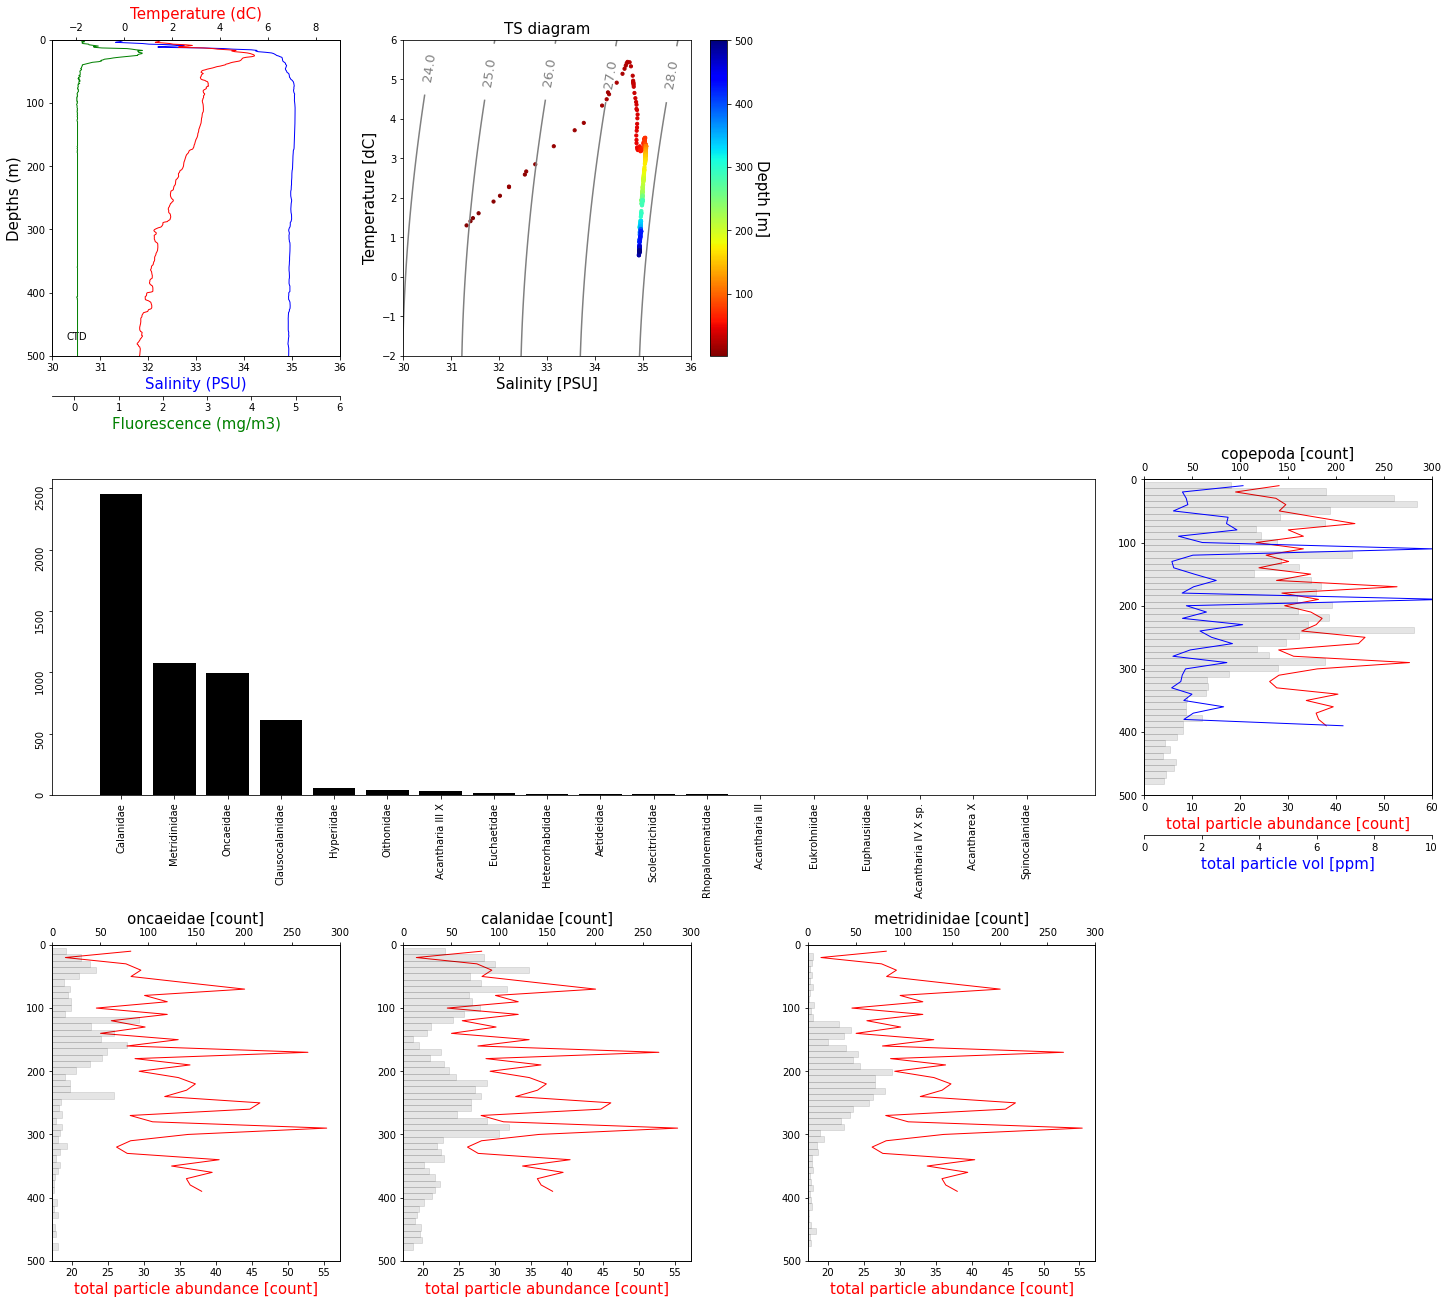

PS107_12_2


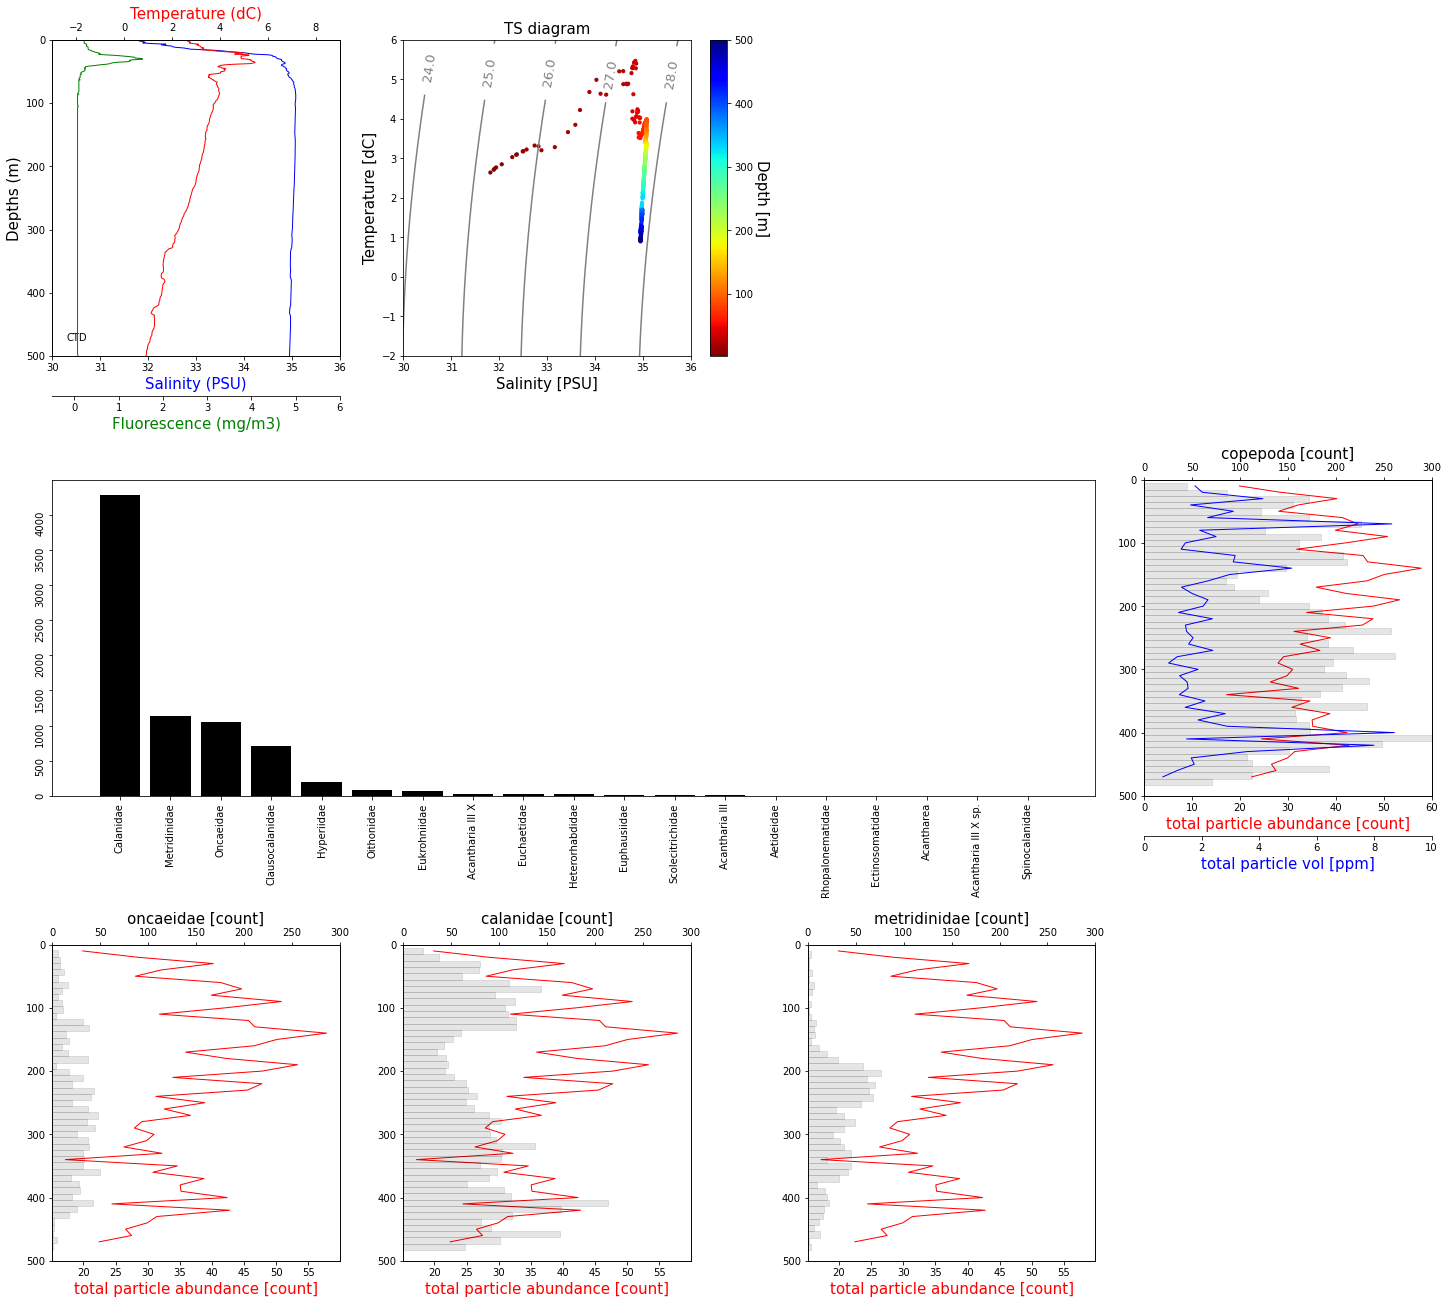

PS107_14_7


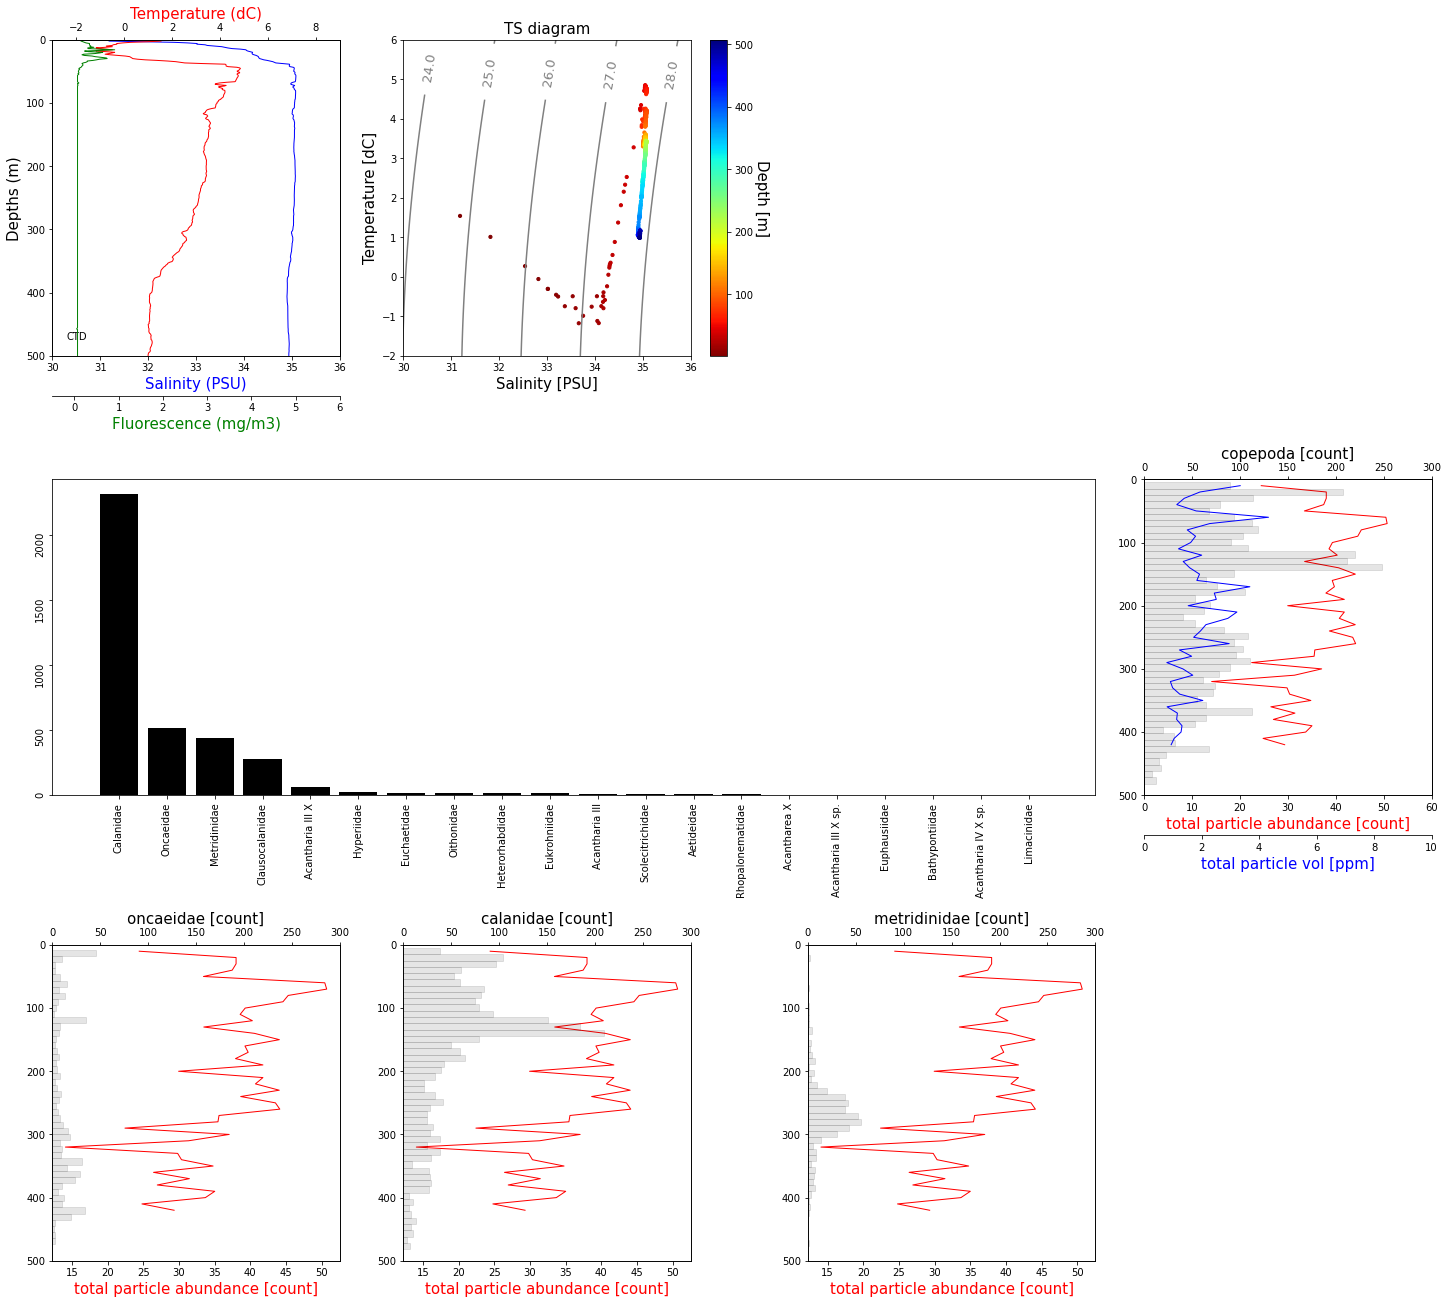

PS107_16_2


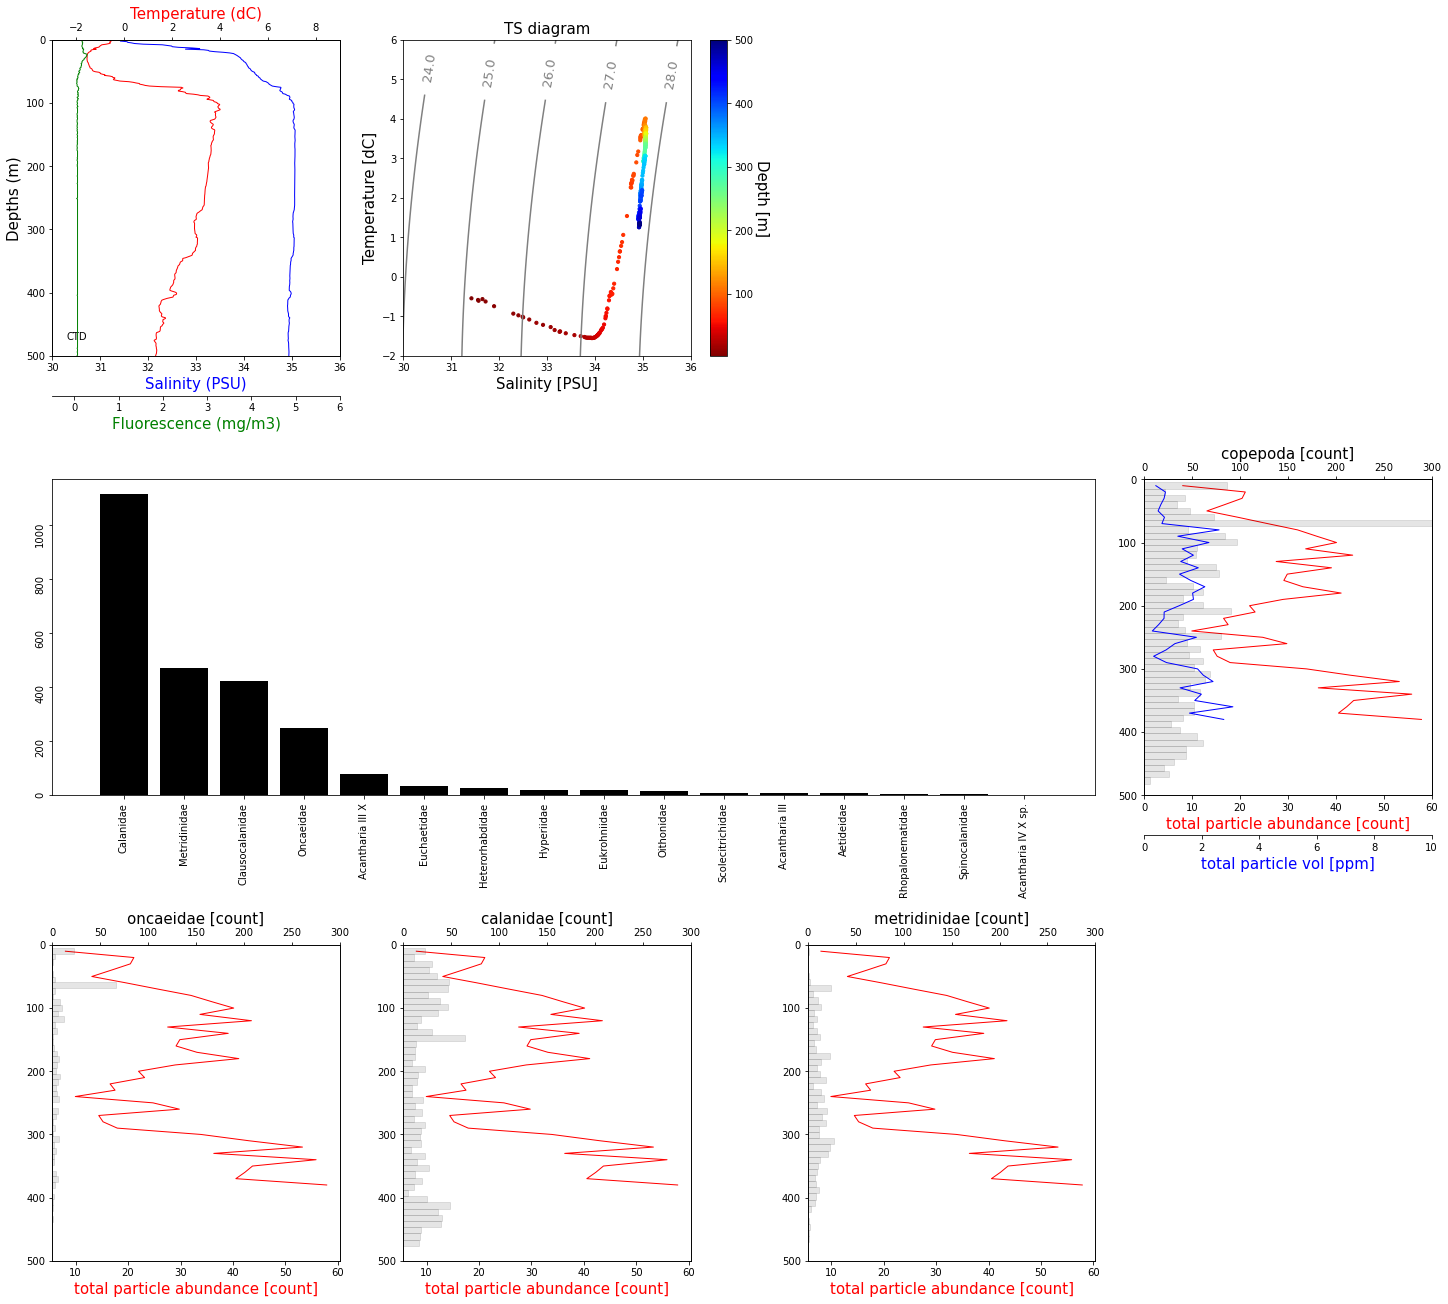

In [16]:
for index, value in isc_each_stb.iterrows():
    # select one station from one isc station and get cruise name, station number and profilenumber of ISC
    cruise, station, profile_num = value['cruise_station_haul'].split('_')[0], int(float(value['cruise_station_haul'].split('_')[1])), int(float(value['profile_number']))
    
    # Based on the cruise and profilenumber of ISC import data from excel file
    isc_excel = str('IR'+str(profile_num).zfill(2)+'_DownCast_'+cruise+'.xlsx')
    for i in isc_file_list:
        if i.split(os.sep)[-1] == isc_excel:
            particle_range = [150, 500, 1000, 100000] # micro meter
            
            # from here specific station.
            isc_ctd_df, vol_spec_df, aggr_con_df, size_spec_df = isc_xlsx(i, 10, particle_range)
            vol, abd, isc_ctd, ctd_dict = isc_summary(isc_ctd_df, vol_spec_df, aggr_con_df, particle_range)
            loki_station_df = loki_df[loki_df['station'].str.contains(cruise+'_'+str(station).zfill(3)) & loki_df['animal']==True] # select corresponding loki station

            if loki_station_df.empty:
                continue
            else:
                print(value['cruise_station_haul'])
                ctd_station_df = ctd_df[ctd_df['Event'].str.contains(cruise+'_'+str(station))] # select corresponding ctd station
                Sal = tuple(pd.to_numeric(ctd_station_df['Sal']))
                Depth = tuple(pd.to_numeric(ctd_station_df['Depth water [m]']))
                Temp = tuple(pd.to_numeric(ctd_station_df['Temp [°C]']))
                Fluo = tuple(pd.to_numeric(ctd_station_df['Fluorometer [arbitrary units]']))
                
                copepoda_df = loki_station_df[loki_station_df['copepod']==True] # df only for copepoda
                copepoda_depth = copepoda_df['loki_depth'].to_list()
                
                oncaeidae_df = loki_station_df[loki_station_df['family']=='Oncaeidae'] # df only for copepoda
                oncaeidae_depth = oncaeidae_df['loki_depth'].to_list()
                
                calanidae_df = loki_station_df[loki_station_df['family']=='Calanidae'] # df only for copepoda
                calanidae_depth = calanidae_df['loki_depth'].to_list()
                
                metridinidae_df = loki_station_df[loki_station_df['family']=='Metridinidae'] # df only for copepoda
                metridinidae_depth = metridinidae_df['loki_depth'].to_list()
                
                loki_family_dict = dict(loki_station_df['family'].value_counts())
                
                
                fig = plt.figure(constrained_layout=True, figsize =(20, 18))
                gs = fig.add_gridspec(3, 4)
                
                #fig, axs = plt.subplots(6,3, figsize = (10, 25))
                #axs = axs.ravel()

                # 1st plot for temperature and salanity and Fluorescence / data from CTD
                ### CTD ###
                ax1 = fig.add_subplot(gs[0,0])
                ax1.plot(Sal, Depth, color ='blue', linewidth= 1)
                ax1.set_ylabel(ctd_dict['depth'], color ='black', fontsize=15)
                ax1.set_xlabel(ctd_dict['sal'], color = 'blue', fontsize=15)
                ax1.set_xlim(30, 36)
                ax1.set_ylim(0,500)
                ax1.annotate('CTD', xy=(0.05, 0.05), xycoords='axes fraction', fontsize=10)

                sec_axs = ax1.twiny()
                sec_axs.plot(Temp, Depth, color='red', linewidth= 1)
                sec_axs.set_xlabel(ctd_dict['temp'], color = 'red', fontsize=15)
                sec_axs.set_xlim(-3, 9)
                
                thr_axs = ax1.twiny()
                thr_axs.spines['bottom'].set_position(('outward', 40))  # make new outmost axis                  
                thr_axs.xaxis.set_ticks_position('bottom')
                thr_axs.xaxis.set_label_position('bottom')
                thr_axs.plot(Fluo, Depth, color='green', linewidth= 1)
                thr_axs.set_xlabel(ctd_dict['fluo'], color = 'green', fontsize=15)
                thr_axs.set_xlim(-0.5, 6)
                thr_axs.invert_yaxis()
                
                # 2nd plot TS diagram                
                mint= -2 # contour for density
                maxt= 6
                mins= 30
                maxs= 36
                
                tempL=np.linspace(mint-1,maxt+1,156)
                salL=np.linspace(mins-1,maxs+1,156)
                
                Tg, Sg = np.meshgrid(tempL,salL)
                sigma_theta = gsw.sigma0(Sg, Tg)
                cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),156) # density contour data generated
                
                ax2 = fig.add_subplot(gs[0,1])
                sc = ax2.scatter(Sal, Temp, c=Depth, cmap = 'jet_r', s=10)
                cs = ax2.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1)
                cl=plt.clabel(cs,fontsize=13,inline=True,fmt='%.1f')
                
                ax2.set_xlim(30, 36)
                ax2.set_ylim(-2, 6)
                ax2.set_title('TS diagram', fontsize=15)
                ax2.set_xlabel('Salinity [PSU]', fontsize=15)
                ax2.set_ylabel('Temperature [dC]', fontsize=15)

                cbar = plt.colorbar(sc)
                cbar.ax.set_ylabel('Depth [m]', rotation=270, labelpad=15, fontsize=15)

                # 3rd plot copepoda
                ax3 = fig.add_subplot(gs[1,:3])
                ax3.bar(loki_family_dict.keys(), loki_family_dict.values(), color='black') # family abundance check
                ax3.tick_params(rotation=90)
                
                # 4th plot all copepoda profile with particle abd and vol
                ax4 = fig.add_subplot(gs[1,3])
                ax4.plot(abd['abd_tol'], isc_ctd['depth'], color='red', linewidth= 1)
                ax4.set_xlabel('total particle abundance [count]', color = 'red', fontsize=15)
                ax4.set_ylim(0,500)
                ax4.set_xlim(0,60)
                

                sec_axs = ax4.twiny()
                sec_axs.hist(copepoda_depth, orientation='horizontal', bins = int(max(copepoda_depth)/10), edgecolor='black', alpha=0.1, color='black')
                sec_axs.set_xlim(0,300)
                sec_axs.set_xlabel('copepoda [count]', color = 'black', fontsize=15)
                

                thr_axs = ax4.twiny()
                thr_axs.spines['bottom'].set_position(('outward', 40))  # make new outmost axis                  
                thr_axs.xaxis.set_ticks_position('bottom')
                thr_axs.xaxis.set_label_position('bottom')
                thr_axs.plot(vol['vol_tol'], isc_ctd['depth'], color='blue', linewidth= 1)
                thr_axs.set_xlabel('total particle vol [ppm]', color = 'blue', fontsize=15)
                thr_axs.set_xlim(0,10)
                thr_axs.invert_yaxis()
                
                
                # each sp. level
                ax5 = fig.add_subplot(gs[2,0])
                ax5.plot(abd['abd_tol'], isc_ctd['depth'], color='red', linewidth= 1)
                ax5.set_xlabel('total particle abundance [count]', color = 'red', fontsize=15)
                ax5.set_ylim(0,500)

                sec_axs = ax5.twiny()
                sec_axs.hist(oncaeidae_depth, orientation='horizontal', bins = int(max(copepoda_depth)/10), edgecolor='black', alpha=0.1, color='black')
                sec_axs.set_xlim(0,300)
                sec_axs.set_xlabel('oncaeidae [count]', color = 'black', fontsize=15)
                sec_axs.invert_yaxis()
                
                
                ax6 = fig.add_subplot(gs[2,1])
                ax6.plot(abd['abd_tol'], isc_ctd['depth'], color='red', linewidth= 1)
                ax6.set_xlabel('total particle abundance [count]', color = 'red', fontsize=15)
                ax6.set_ylim(0,500)

                sec_axs = ax6.twiny()
                sec_axs.hist(calanidae_depth, orientation='horizontal', bins = int(max(copepoda_depth)/10), edgecolor='black', alpha=0.1, color='black')
                sec_axs.set_xlim(0,300)
                sec_axs.set_xlabel('calanidae [count]', color = 'black', fontsize=15)
                sec_axs.invert_yaxis()
                
                
                ax7 = fig.add_subplot(gs[2,2])
                ax7.plot(abd['abd_tol'], isc_ctd['depth'], color='red', linewidth= 1)
                ax7.set_xlabel('total particle abundance [count]', color = 'red', fontsize=15)
                ax7.set_ylim(0,500)

                sec_axs = ax7.twiny()
                sec_axs.hist(metridinidae_depth, orientation='horizontal', bins = int(max(copepoda_depth)/10), edgecolor='black', alpha=0.1, color='black')
                sec_axs.set_xlim(0,300)
                sec_axs.set_xlabel('metridinidae [count]', color = 'black', fontsize=15)
                sec_axs.invert_yaxis()

                #os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
                #fig_name = str('ISC_LOKI_'+value['cruise_station_haul']+'.png')
                #plt.savefig(fig_name, facecolor='w')
                plt.show()
                plt.close()